# ISE 529 HW 5
## Session: W
## Group Members: Naichang LU, Feiyang GU, Qikai GAO, Yihang ZHANG

## Pre-processing

In [1]:
# data analysis and wrangling
import pandas as pd
import numpy as np
import random as rnd

# visualization
import matplotlib.pyplot as plt
%matplotlib inline

# machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn import metrics, model_selection, linear_model

In [2]:
# set random seed to 1 so that this produces result that is repeatable.
np.random.seed(1)

In [3]:
# Generating data as required
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
combine = [train_df, test_df]

train_df = train_df.drop(['Ticket', 'Cabin'], axis=1)
test_df = test_df.drop(['Ticket', 'Cabin'], axis=1)
combine = [train_df, test_df]

for dataset in combine:
    dataset['Title'] = dataset.Name.str.extract(r' ([A-Za-z]+)\.', expand=False)

for dataset in combine:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col',\
 	'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
for dataset in combine:
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)

train_df = train_df.drop(['Name', 'PassengerId'], axis=1)
test_df = test_df.drop(['Name'], axis=1)
combine = [train_df, test_df]
train_df.shape, test_df.shape

for dataset in combine:
    dataset['Sex'] = dataset['Sex'].map( {'female': 1, 'male': 0} ).astype(int)

guess_ages = np.zeros((2,3))
guess_ages

for dataset in combine:
    for i in range(0, 2):
        for j in range(0, 3):
            guess_df = dataset[(dataset['Sex'] == i) & \
                                  (dataset['Pclass'] == j+1)]['Age'].dropna()

            # age_mean = guess_df.mean()
            # age_std = guess_df.std()
            # age_guess = rnd.uniform(age_mean - age_std, age_mean + age_std)

            age_guess = guess_df.median()

            # Convert random age float to nearest .5 age
            guess_ages[i,j] = int( age_guess/0.5 + 0.5 ) * 0.5
            
    for i in range(0, 2):
        for j in range(0, 3):
            dataset.loc[ (dataset.Age.isnull()) & (dataset.Sex == i) & (dataset.Pclass == j+1),\
                    'Age'] = guess_ages[i,j]

    dataset['Age'] = dataset['Age'].astype(int)

train_df['AgeBand'] = pd.cut(train_df['Age'], 5)
train_df[['AgeBand', 'Survived']].groupby(['AgeBand'], as_index=False).mean().sort_values(by='AgeBand', ascending=True)

for dataset in combine:    
    dataset.loc[ dataset['Age'] <= 16, 'Age']                          = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age']                           = 4
    # np.piecewise() # this author is stupid

train_df = train_df.drop(['AgeBand'], axis=1)
combine = [train_df, test_df]

for dataset in combine:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1

for dataset in combine:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1

train_df = train_df.drop(['Parch', 'SibSp', 'FamilySize'], axis=1)
test_df = test_df.drop(['Parch', 'SibSp', 'FamilySize'], axis=1)
combine = [train_df, test_df]

for dataset in combine:
    dataset['Age*Class'] = dataset.Age * dataset.Pclass

freq_port = train_df.Embarked.dropna().mode()[0]

for dataset in combine:
    dataset['Embarked'] = dataset['Embarked'].fillna(freq_port)

for dataset in combine:
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)

test_df['Fare'].fillna(test_df['Fare'].dropna().median(), inplace=True)

train_df['FareBand'] = pd.qcut(train_df['Fare'], 4)

for dataset in combine:
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] = 3
    dataset['Fare'] = dataset['Fare'].astype(int)

train_df = train_df.drop(['FareBand'], axis=1)
combine = [train_df, test_df]

In [4]:
X_train = train_df.drop("Survived", axis=1)
Y_train = train_df["Survived"]
X_test  = test_df.drop("PassengerId", axis=1).copy()
X_train.shape, Y_train.shape, X_test.shape

((891, 8), (891,), (418, 8))

### Predictors

- Pclass
    - (categorical) Passenger class
- Sex
    - (binary) 1 if female, 0 if male
- Age
    - (categorical) Age group
- Fare
    - (categorical) Fare group
- Embarked
    - (categorical) The port which the passenger embarked
- IsAlone
    - (binary) 1 if alone, else 0
- Age * Class
    - (Numeric) Age group * Passenger class group (?)

In [5]:
X_train.head()

,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone,Age*Class
0,3,0,1,0,0,1,0,3
1,1,1,2,3,1,3,0,2
2,3,1,1,1,0,2,1,3
3,1,1,2,3,0,3,0,2
4,3,0,2,1,0,1,1,6


In [6]:
X_train.shape

(891, 8)

In [15]:
# Certain classifiers works better with one-hot encoded variables.
# Let's do one hot encoding.
dummy_columns = ["Pclass", "Age", "Fare", "Embarked", "Title"]
n_train = len(X_train)
combine = pd.concat([X_train, X_test])
combine.shape
combine_dummy = pd.get_dummies(combine, columns=dummy_columns, drop_first=True)
X_train_dummy = combine_dummy[:n_train]
X_test_dummy = combine_dummy[n_train:]
print(X_train_dummy.shape, X_test_dummy.shape)

(891, 18) (418, 18)


In [8]:
# A helper function
# Takes a model and get the 5-fold cross validation
# score under specified metric
def getScore(model, X_train, Y_train, metric=metrics.accuracy_score):
    cv = model_selection.KFold(n_splits=5, random_state=1)
    score = model_selection.cross_val_score(model,
            X_train,Y_train,scoring=metrics.make_scorer(metric), cv=cv)
    return score.mean()

In [9]:
# These are the classifiers that requires one-hot encoding.
# Notice that we add random_state=1 to classifiers that either:
# whose model depends on random state; or
# optimization of the model depends on stochastic methods.
model_dict_dummy = {
    'Support Vector Machines':SVC(gamma='auto', random_state=1),
    'KNN':KNeighborsClassifier(n_neighbors = 3),
    'Logistic Regression':LogisticRegression(solver='lbfgs', random_state=1),
    'Naive Bayes':GaussianNB(),
    'Perceptron':Perceptron(),
    'Stochastic Gradient Descent':SGDClassifier(random_state=1),
    'Linear SVC':LinearSVC(max_iter=10000, random_state=1)
}

# These are the classifiers that requires one-hot encoding.
model_dict = {
     'Random Forest':RandomForestClassifier(n_estimators=100, random_state=1),
     'Decision Tree':DecisionTreeClassifier(random_state=1)
}

model_name = list(model_dict.keys())
model_dummy_name = list(model_dict_dummy.keys())

score_list = (
    [getScore(model_dict[n],X_train,Y_train) for n in model_name]
    + [getScore(model_dict_dummy[n] ,X_train_dummy,Y_train)
       for n in model_dummy_name]
)

score_pd = pd.DataFrame({'model': model_name + model_dummy_name,'Accuracy rate':score_list}) 
score_pd.sort_values(by='Accuracy rate', ascending=False)

,model,Accuracy rate
0,Random Forest,0.803616
8,Linear SVC,0.802498
4,Logistic Regression,0.802479
2,Support Vector Machines,0.800207
1,Decision Tree,0.793516
3,KNN,0.780083
7,Stochastic Gradient Descent,0.705932
5,Naive Bayes,0.695838
6,Perceptron,0.641190


## Question 2

In [10]:
from xgboost import XGBClassifier
from scipy import stats

In [11]:
# Using a grid search and to find the optimal set of hyperparameters for XGBoost
cv = model_selection.KFold(n_splits=5)
xgb_param_grid = {
    "n_estimators": np.arange(50, 1001, 50),
    "max_depth": np.arange(2, 10)
}
xgb = model_selection.GridSearchCV(XGBClassifier(random_state=1, silent=True),
    xgb_param_grid, cv=cv, scoring="accuracy", return_train_score=True, n_jobs=-1)
xgb.fit(X_train, Y_train)
xgb_best_param = xgb.best_params_

In [12]:
# Using the hyperparameters obtained above, we fit a new XGBoost model.
X_tr, X_te, Y_tr, Y_te = model_selection.train_test_split(
    X_train, Y_train, test_size=0.3, random_state=1
)
xgb = XGBClassifier(n_estimators=xgb_best_param["n_estimators"],
    max_depth=xgb_best_param["max_depth"]
).fit(X_tr, Y_tr)
pred = xgb.predict(X_te)
xgb.score(X_te,Y_te)

0.7835820895522388

In [13]:
# AUC Metric
pred_proba = xgb.predict_proba(X_te)
auc = metrics.roc_auc_score(Y_te,pred_proba[:,1])
print(auc)

0.8254617789144645


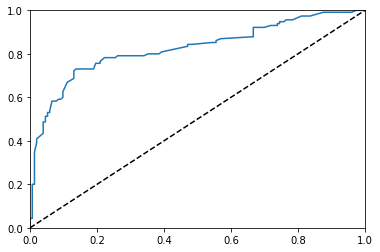

In [31]:
# Plot the ROC graph
fpr,tpr,thresholds = metrics.roc_curve(Y_te,pred_proba[:,1])
plt.plot(fpr,tpr)
plt.plot([0,1],[0,1],'k--')
plt.axis([0,1,0,1]);

### Conclusion: Accuracy = 0.783 AUC = 0.825


## Question 3

In [35]:
# To use an ensemble model, we combine the non-dummy and dummy variables apart
pd.get_dummies(combine, columns=dummy_columns, drop_first=True,)

,Sex,IsAlone,Age*Class,Pclass_2,Pclass_3,Age_1,Age_2,Age_3,Age_4,Fare_1,Fare_2,Fare_3,Embarked_1,Embarked_2,Title_2,Title_3,Title_4,Title_5
0,0,0,3,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,2,0,0,0,1,0,0,0,0,1,1,0,0,1,0,0
2,1,1,3,0,1,1,0,0,0,1,0,0,0,0,1,0,0,0
3,1,0,2,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0
4,0,1,6,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,0,1,3,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0
414,1,1,2,0,0,0,1,0,0,0,0,1,1,0,0,0,0,1
415,0,1,6,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0
416,0,1,3,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0


In [17]:
import sklearn.base
class my_ensemble_model(sklearn.base.BaseEstimator):

    def fit(self, X_train, Y_train, hold=False, **param):
        assert("split_pos" in param)
        
        self.models = list(model_dict.values())
        if not hold:
            for model in self.models:
                model.fit(X_train, Y_train)
        return self
            
    def predict(self, X_test):
        pred_list = np.vstack([model.predict(X_test) for model in self.models])
        #mod = np.squeeze((pred_list.mean(axis=0) > 0.5).astype(int))
        return pred_list

In [29]:
#getScore(my_ensemble_model(), X_train, Y_train)
#getScore(my_ensemble_model(), X_train_dummy, Y_train)

result = pd.DataFrame()
for model_key,model in model_dict.items():
    model.fit(X_train,Y_train)
    result[model_key] = model.predict(X_train)

for model_key,model in model_dict_dummy.items():
    model.fit(X_train_dummy,Y_train)
    result[model_key] = model.predict(X_train_dummy)

ensemble_res = np.round(result.mean(axis=1)).astype(int)
print(ensemble_res)
metrics.accuracy_score(Y_train,ensemble_res)
    

0      0
1      1
2      1
3      1
4      0
      ..
886    0
887    1
888    0
889    1
890    0
Length: 891, dtype: int32


0.8282828282828283

### The accuracy rate of the ensemble_model is 0.810.

## Question 4

In [ ]:
class zero_model(sklearn.base.BaseEstimator):

    def fit(self, X_train, Y_train):
        return self
            
    def predict(self, X_test):
        x_len = X_test.shape[0]
        return np.zeros(x_len)

In [ ]:
del model_dict['Stochastic Gradient Descent']

model_dict['zero']=zero_model()
getScore(my_ensemble_model(), X_train, Y_train)

### The accuracy rate of the new ensemble_model is 0.806.

## Question 5

In [ ]:
# Let's clear the models and fit new ones with
# hyperparamter selection.
for key in list(model_dict.keys()):
    del model_dict[key]

In [ ]:
# First center and normalize the data as follows.
# Here are the first five lines of the processed data
X_train_scaled = (X_train - X_train.mean(axis=0)) / X_train.std(axis=0)
X_train_scaled.head()

In [ ]:
# Cross validator
cv = model_selection.KFold(n_splits=5, random_state=1)

In [ ]:
%%time
# KNN
knn_grid = {"n_neighbors" : np.arange(1, 15), "p": [1, 2], } 
knn = model_selection.GridSearchCV(KNeighborsClassifier(), knn_grid,
          scoring="accuracy", cv=cv, n_jobs=-1)
knn.fit(X_train_scaled, Y_train)
print(knn.score(X_train_scaled, Y_train))

In [ ]:
%%time
# Logistic Regression
logreg = linear_model.LogisticRegressionCV(cv=cv, max_iter=1000, random_state=1)
logreg.fit(X_train_scaled, Y_train)
print(logreg.score(X_train_scaled, Y_train))

In [ ]:
%%time
# SVC
svc_param_grid = {
    "kernel" : ['linear', 'rbf', 'poly'],
    "C" : np.logspace(-3, 1, 5),
    "gamma" : ["auto", "scale"],
    "degree" : np.arange(5)
}

svc = model_selection.GridSearchCV(SVC(random_state=1), svc_param_grid,
        scoring="accuracy", cv=cv, n_jobs=-1)
svc.fit(X_train_scaled, Y_train)

print(svc.score(X_train_scaled, Y_train))

In [ ]:
# XGBoost has to be manually tuned
# We split the training data to get a validation set.
X_tr, X_val, Y_tr, Y_val = model_selection.train_test_split(
    X_train_scaled, Y_train, test_size=0.3)
eval_set = ((X_tr, Y_tr), (X_val, Y_val))
eval_metric = ["auc", "error"]

In [ ]:
%%time
# Using the validation set we tune the hyperparameters of XGBClassifier.
# To avoid overfitting and wasting computation, we stop after 200 trees.
xgb = XGBClassifier(scale_pos_weight=1,
                  learning_rate=0.01,  
                  colsample_bytree=0.8,
                  subsample=0.8,
                  objective='binary:logistic', 
                  n_estimators=200, 
                  reg_alpha=0.3,
                  max_depth=3, 
                  gamma=1,
                  random_state=1
                )
xgb.fit(X_tr, Y_tr, eval_metric=eval_metric, eval_set=eval_set,
          verbose=50);

In [ ]:
# After that we use the hyperparameters and fit on the whole training set.
xgb.fit(X_train_scaled, Y_train)
print(xgb.score(X_train_scaled, Y_train))

In [ ]:
# Random Forest Classifier
rfc = RandomForestClassifier(n_estimators=100)
rfc.fit(X_train_scaled, Y_train);

In [ ]:
# We ensemble these three methods, and do not refit.
model_dict = {
    "knn": knn,
    "xgb": xgb,
    "logreg": logreg,
    "svc": svc,
    "random forest": rfc
}
model = my_ensemble_model().fit(X_train_scaled, Y_train, hold=True)

In [ ]:
# Now scale the test data along with the training data.
# Here are the first five row of the transformed test data.
X_combine = pd.concat([X_train, X_test])
X_test_scaled = (X_test - X_combine.mean(axis=0)) / X_combine.std(axis=0)
X_test_scaled.head()

In [ ]:
# Last we use our ensemble model to make predictions.
pred = model.predict(X_test_scaled)

In [ ]:
# We assemble the predictions in order to make submission to kaggle.
submission = pd.DataFrame(
    {
        "PassengerID": test_df["PassengerId"],
        "Survived": pred
    }
)
submission.head()

In [ ]:
submission.to_csv("submission.csv", index=False)

In [ ]:
# Done!

### Conslusion: With the latest submission to Kaggle under team name "miaonima" at 12:10 pm 11/19/2019, the score for public test is 0.79904. 